In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from auxiliary import (read_results, create_tables, create_plots, create_nfxp_plots)

---
## General Formulation of MPEC for economic models
---

Assume an economic model is described by the parameter vector $\theta$ and a state vector $x$ as well as some endogeneous variables $\sigma$. The data consists of $X = \{x_i, d_i\}^M_{i=1}$. $x_i$ is the observed state and $d_i$ is the observed equilibrium outcome of the underlying decision model. $M$ is the number of data points.

Generally $\sigma$ depends on the parameters $\theta$ through a set of equlibrium conditions. This also includes Bellman Equations. This consistency is expressed by the following condition: 

\begin{align}
h(\theta, \sigma) = 0.
\end{align}

For a given $\theta$, let $\Sigma(\theta)$ denote the set of $\sigma(\theta)$ for which the equilibrium conditions hold, i.e. $h(\theta,\sigma)=0$. 

\begin{align}
\Sigma(\theta) := \{\sigma:h(\theta, \sigma)=0\}.
\end{align}

Let $\sigma\hat(\theta)$ denote an element of the above set. In the case of the a dynamic discrete-choice model, this represents the expected value function. This set does not have to be a singleton for a given $\theta$ (imagine e.g. a game with multiple equilibria).

For the case of multiple $\sigma\hat(\theta)$ the solution to the maximation of the log likehood function is:

\begin{align}
\hat\theta = argmax_\theta \{max_{\hat\sigma(\theta)\in\Sigma(\theta)} L(\theta,\hat\sigma(\theta); X)\}.
\end{align}

**NFXP**

The nested fixed point algorithm now attempts to evaluate the above log likelihood function $L(.)$ by searching for a $\theta$ that maximizes it in an outer loop and then, for a given $\theta$, caluclates all $\hat\sigma(\theta)\in\Sigma(\theta)$ while choosing the one that gives the highest log likelihood (in case $\Sigma(\theta)$ is not a singleton).

**MPEC** 

MPEC now goes a different way of ensuring that a guess of $\theta$ is consistent with the equilibrium condition $h(\theta, \sigma)=0$. It models $\sigma$ explicitly as another parameter vector and makes sure that the equilibrium condition holds by imposing it as a constraint to the new log likelihood function. More formally the log likehood function now becomes $L(\theta, \sigma; X)$ and the optimization problem now becomes a constrained optimization looking like the following:

\begin{align}
max_{(\theta, \sigma)} L(\theta, \sigma; X) 
\end{align}
\begin{align}
subject\: to\: h(\theta, \sigma) = 0.
\end{align}

Su & Judd (2012) provide a proof that those two formulations are actually equivalent in the sense that they yield the same solutions for $\hat\theta$. Further they state that MPEC also works for GMM (see Dubé, Fox and Su (2012)) as well as simulated maximum likelihood.

---
## Practical Consequences following Rust's Engine Replacement Problem
---

In the case of Rust's Engine Replacement problem where we discretize the mileage into a grid of 90 (i.e. $\sigma$ consists of 90 elements) and assume the cost function to be linear (i.e. $\theta$ consists of two elements), the MPEC problem consists of 90 nonlinear constraints and 92 parameters. Depending on the complexity of the model the amount of non-linear constraints will quickly become quite large. Su & Judd (2012) report, though, that they successfully solved a structural model with 100,042 constrains and 100,052 parameters within an hour on a 12 GB RAM work station. The constraint Jacobian as well as the Hessian of the Lagrangian were sparse, though, and they provided analytical first and second order derivatives (by using automatic differentiation) as well as their sparsity patterns. This was possible by using KNITRO and won't be with nlopt. In the case of ipopt this is generally possible but python yet seems to lack an efficient tool to perform automatic differentiation applicable to structural models. 

The big advantage of MPEC is that it is comparably easy to code up as the whole code regarding the solving of the economic model is not needed to be set up. Furthermore at each guess MPEC makes sure that the guess of the parameters is consistent with the economic model and hence it is not necessary to explicitly solve the model at each single guess. Above that constrained algorithms such as ipopt do not enforce the constraints to hold exactly until the algorithm reaches the last iteration. Those two features make it possible that MPEC potentially becomes faster than the NFXP when estimating structural models. Dubé, Fox and Su (2012) report, though, that this possible speed advantage might only be strong if the constraint Jacobian as well as the Hessian of the Lagragian are sparse.

---
## Applicability to respy
---

Please read this section as the starting point for discussion.

- Theoretically it seems possible to use MPEC for the estimation. In that case it seems necessary to impose as many nonlinear conditions as there are possible $EMAX$. All those are also modelled explicitly in the log likelihood function as parameters to be estimated. Hence, their dependence on the parameter vector $\theta$ does not enter the log likelihood function. In the language from before $EMAX$ would be our $\sigma$ and the condition that $\sigma$ and $\theta$ are consistent with each other is cast to the constraints.

- In the case of ruspy, this seriously simplified the calculation as the whole calculation for the fixed point (contraction mapping and N-K iterations) was omitted. So the increase in dimensionality of the problem for MPEC was offset by the fact that all the fixed point iterations were not needed anymore. As far as I can see it (although I cannot claim to have fully grasped what is going on in respy as well as Keane & Wolpin (1994, 1997)), this advantage won't be as prominent for respy as this problem has a finite horizon and is solved by backward induction. Hence, no fixed point has to be calculated and therefore no iteration is necessary. With MPEC via ipopt, though, the backward induction does not have to be conducted all the way through such that it holds exactly.

- Unforunately, the set up from Su and Judd (2012) cannot be easily applied to respy. First of all, a closed-form first derivative does not exist and hence cannot be found by automatic differentiation (neither does the Hessian, of course, as well as the sparsity patterns). For this reason, I have included a simulation below that is supposed to investigate the sensitivity of MPEC to the use of numerical derivatives following Iskhakov et al. (2016).

---
## Showcasing the response of MPEC to numerical gradients
---

Below I will follow the general setup of Iskhakov et al. (2016) as done in my replication notebook of the paper using ruspy (https://github.com/OpenSourceEconomics/ruspy/blob/replication_notebook_and_documentation/promotion/replication/replication_iskhakov_et_al_2016.ipynb).

In the following I run the setup of the named notebook on a smaller scale. I run 600 estimations as opposed to 5000. I use the originally simulated data form the paper for six different $\beta$ which I then estimate with five different starting values each. This I perform for MPEC four times. Once I use ipopt as an algorithm tool and compare its performance with analytical first order derivatives to its performance with finite difference derivatives. This I repeat using the optimizer "LD_SLSQP" from nlopt. Lastly as a comparison I run the same setup with a nested fixed point algorithm. 

I find that the convergence rate of MPEC stays high irrespective of using ipopt or nlopt. For very high $\beta$ the numerical derivative introduces a slight upward bias, though. The number of function evaluations and iterations needed by ipopt and nlopt goes slightly up but overall stays quite comparable between using analytical and numerical derivatives. The CPU time is around three times as high in the case of numerical derivatives. This is likely also partly due to the amount of function evaluations necessary to get the numerical derivatives (note that the number of function evaluations in the tables just account for the calls of the algorithm but not that for the numerical approximation of the derivative). This is computationally more expensive in the case of MPEC in comparison to NFXP as the dimensionality of the problem of MPEC is much higher. The gradient of the NFXP is only a 2 dimensional vector while in the case of MPEC the gradient of the criterion function is a 177 dimensional vector and the Jacobian of the constraint is a $175 \times 177$ matrix. At the same time, though, in the case of NFXP for the numerical approximation of the derivative it is necessary to repeatedly calculate the fixed point of the expected value function whenever the function is called by the approximation procedure. This introduces a strong dependance of the NFXP on an efficient implementation of the model solving procedure (fixed point calculation). In our ruspy implementation of the NFXP the fixed point calculation seems to work quite well as even several thousand iterations are done quickly but at the same time in the very high regions of $\beta$ our NFXP becomes quite instable which leads to a low convergence rate when using numerical derivatives.

### Get the results of the estimation strategies

In [2]:
# Get the results of the six estimation strategies
results_ipopt, results_nlopt, results_nfxp = read_results()
results = [results_ipopt, results_nlopt, results_nfxp]

In [3]:
# let's look at one dataframe to get an idea
results_ipopt

RC theta_11 CPU Time  \
Discount Factor Run Start Approach                                      
0.9750          0   0     MPEC              8.89422  1.55117    1.187   
                          MPEC (numerical)  8.89437  1.55123    4.143   
                    1     MPEC              8.89422  1.55117    0.919   
                          MPEC (numerical)  8.89437  1.55123    2.854   
                    2     MPEC              8.89422  1.55117    0.959   
...                                             ...      ...      ...   
0.9999          9   2     MPEC (numerical)  10.8505   2.2258    4.574   
                    3     MPEC              10.6258  2.14888    1.834   
                          MPEC (numerical)  10.8476  2.22483    7.725   
                    4     MPEC              10.6258  2.14888    1.863   
                          MPEC (numerical)  10.8474  2.22474    3.974   

                                           Converged # of Major Iter.  \
Discount Factor Run Start Approach                                      
0.9750          0   0     MPEC                     1               23   
                          MPEC (numerical)         1               23   
                    1     MPEC                     1               15   
                          MPEC (numerical)         1               15   
                    2     MPEC                     1               19   
...                                              ...              ...   
0.9999          9   2     MPEC (numerical)         1               28   
                    3     MPEC                     1               31   
                          MPEC (numerical)         1               48   
                    4     MPEC                     1               30   
                          MPEC (numerical)         1               24   

                                           # of Func. Eval. # of Bellm. Iter.  \
Discount Factor Run Start Approach                                              
0.9750          0   0     MPEC                           29               NaN   
                          MPEC (numerical)               29               NaN   
                    1     MPEC                           17               NaN   
                          MPEC (numerical)               17               NaN   
                    2     MPEC                           23               NaN   
...                                                     ...               ...   
0.9999          9   2     MPEC (numerical)               41               NaN   
                    3     MPEC                           65               NaN   
                          MPEC (numerical)              136               NaN   
                    4     MPEC                           61               NaN   
                          MPEC (numerical)               39               NaN   

                                           # of N-K Iter.  
Discount Factor Run Start Approach                         
0.9750          0   0     MPEC                        NaN  
                          MPEC (numerical)            NaN  
                    1     MPEC                        NaN  
                          MPEC (numerical)            NaN  
                    2     MPEC                        NaN  
...                                                   ...  
0.9999          9   2     MPEC (numerical)            NaN  
                    3     MPEC                        NaN  
                          MPEC (numerical)            NaN  
                    4     MPEC                        NaN  
                          MPEC (numerical)            NaN  

[600 rows x 8 columns]

### Create tables showing the means and standard deviations

In [4]:
# Create tables with means and standard deviations
tables = create_tables(results)

In [5]:
# MPEC with ipopt
tables["ipopt"].astype(float).round(4)

RC  theta_11  \
Discount Factor Approach         Statistic                               
0.9750          MPEC             Mean                11.4877    2.4181   
                                 Standard Deviation   1.2122    0.3990   
                MPEC (numerical) Mean                11.4881    2.4182   
                                 Standard Deviation   1.2124    0.3991   
0.9850          MPEC             Mean                12.0694    2.5473   
                                 Standard Deviation   1.6792    0.5293   
                MPEC (numerical) Mean                12.0706    2.5477   
                                 Standard Deviation   1.6798    0.5295   
0.9950          MPEC             Mean                11.8233    2.4418   
                                 Standard Deviation   1.3411    0.3849   
                MPEC (numerical) Mean                11.8282    2.4434   
                                 Standard Deviation   1.3428    0.3854   
0.9990          MPEC             Mean                11.9685    2.5288   
                                 Standard Deviation   1.3180    0.4386   
                MPEC (numerical) Mean                11.9986    2.5387   
                                 Standard Deviation   1.3282    0.4419   
0.9995          MPEC             Mean                12.0823    2.5746   
                                 Standard Deviation   1.4332    0.4690   
                MPEC (numerical) Mean                12.1109    2.5874   
                                 Standard Deviation   1.4491    0.4779   
0.9999          MPEC             Mean                11.9333    2.5222   
                                 Standard Deviation   1.5556    0.5083   
                MPEC (numerical) Mean                12.2357    2.6223   
                                 Standard Deviation   1.7018    0.5613   

                                                     CPU Time  Converged  \
Discount Factor Approach         Statistic                                 
0.9750          MPEC             Mean                  1.1025     1.0000   
                                 Standard Deviation    0.1517     0.0000   
                MPEC (numerical) Mean                  3.4097     1.0000   
                                 Standard Deviation    0.4083     0.0000   
0.9850          MPEC             Mean                  1.0804     1.0000   
                                 Standard Deviation    0.1495     0.0000   
                MPEC (numerical) Mean                  3.2521     1.0000   
                                 Standard Deviation    0.4574     0.0000   
0.9950          MPEC             Mean                  1.2309     1.0000   
                                 Standard Deviation    0.1837     0.0000   
                MPEC (numerical) Mean                  3.7201     1.0000   
                                 Standard Deviation    0.6851     0.0000   
0.9990          MPEC             Mean                  1.5133     1.0000   
                                 Standard Deviation    0.1992     0.0000   
                MPEC (numerical) Mean                  4.4639     1.0000   
                                 Standard Deviation    0.6609     0.0000   
0.9995          MPEC             Mean                  1.5791     1.0000   
                                 Standard Deviation    0.2659     0.0000   
                MPEC (numerical) Mean                  4.5781     0.9800   
                                 Standard Deviation    0.7390     0.1414   
0.9999          MPEC             Mean                  1.6509     1.0000   
                                 Standard Deviation    0.2211     0.0000   
                MPEC (numerical) Mean                  5.2843     0.9600   
                                 Standard Deviation    1.6146     0.1979   

                                                     # of Major Iter.  \
Discount Factor Approach         Statistic                              
0.9750    

In [6]:
# MPEC with nlopt
tables["nlopt"].astype(float).round(4)

RC  theta_11  \
Discount Factor Approach         Statistic                               
0.9750          MPEC             Mean                11.4877    2.4181   
                                 Standard Deviation   1.2122    0.3990   
                MPEC (numerical) Mean                11.4881    2.4182   
                                 Standard Deviation   1.2124    0.3991   
0.9850          MPEC             Mean                12.0694    2.5473   
                                 Standard Deviation   1.6792    0.5293   
                MPEC (numerical) Mean                12.0706    2.5477   
                                 Standard Deviation   1.6798    0.5295   
0.9950          MPEC             Mean                11.8233    2.4418   
                                 Standard Deviation   1.3411    0.3849   
                MPEC (numerical) Mean                11.8282    2.4434   
                                 Standard Deviation   1.3428    0.3854   
0.9990          MPEC             Mean                11.9684    2.5288   
                                 Standard Deviation   1.3179    0.4385   
                MPEC (numerical) Mean                11.9987    2.5388   
                                 Standard Deviation   1.3283    0.4419   
0.9995          MPEC             Mean                12.0824    2.5746   
                                 Standard Deviation   1.4332    0.4691   
                MPEC (numerical) Mean                12.1469    2.5958   
                                 Standard Deviation   1.4567    0.4766   
0.9999          MPEC             Mean                11.9336    2.5223   
                                 Standard Deviation   1.5555    0.5082   
                MPEC (numerical) Mean                12.2530    2.6281   
                                 Standard Deviation   1.6982    0.5544   

                                                     CPU Time  Converged  \
Discount Factor Approach         Statistic                                 
0.9750          MPEC             Mean                  1.1303        1.0   
                                 Standard Deviation    0.1653        0.0   
                MPEC (numerical) Mean                  3.3910        1.0   
                                 Standard Deviation    0.4715        0.0   
0.9850          MPEC             Mean                  1.2295        1.0   
                                 Standard Deviation    0.1479        0.0   
                MPEC (numerical) Mean                  3.6155        1.0   
                                 Standard Deviation    0.5025        0.0   
0.9950          MPEC             Mean                  1.4229        1.0   
                                 Standard Deviation    0.1899        0.0   
                MPEC (numerical) Mean                  4.1966        1.0   
                                 Standard Deviation    0.6704        0.0   
0.9990          MPEC             Mean                  1.7037        1.0   
                                 Standard Deviation    0.2113        0.0   
                MPEC (numerical) Mean                  4.9936        1.0   
                                 Standard Deviation    0.7092        0.0   
0.9995          MPEC             Mean                  1.8252        1.0   
                                 Standard Deviation    0.2104        0.0   
                MPEC (numerical) Mean                  5.3691        1.0   
                                 Standard Deviation    0.6872        0.0   
0.9999          MPEC             Mean                  1.9466        1.0   
                                 Standard Deviation    0.2339        0.0   
                MPEC (numerical) Mean                  5.6582        1.0   
                                 Standard Deviation    0.7512        0.0   

                                                     # of Major Iter.  \
Discount Factor Approach         Statistic                              
0.9750    

In [7]:
# NFXP
tables["nfxp"].astype(float).round(4)

RC  theta_11  \
Discount Factor Approach         Statistic                               
0.9750          NFXP             Mean                11.4877    2.4181   
                                 Standard Deviation   1.2122    0.3990   
                NFXP (numerical) Mean                11.4877    2.4181   
                                 Standard Deviation   1.2122    0.3990   
0.9850          NFXP             Mean                12.0694    2.5473   
                                 Standard Deviation   1.6792    0.5293   
                NFXP (numerical) Mean                12.0694    2.5473   
                                 Standard Deviation   1.6792    0.5293   
0.9950          NFXP             Mean                11.8233    2.4418   
                                 Standard Deviation   1.3411    0.3849   
                NFXP (numerical) Mean                11.8233    2.4418   
                                 Standard Deviation   1.3411    0.3849   
0.9990          NFXP             Mean                11.9684    2.5288   
                                 Standard Deviation   1.3179    0.4385   
                NFXP (numerical) Mean                11.8309    2.4730   
                                 Standard Deviation   1.2936    0.4239   
0.9995          NFXP             Mean                12.0824    2.5746   
                                 Standard Deviation   1.4332    0.4691   
                NFXP (numerical) Mean                11.8405    2.5110   
                                 Standard Deviation   1.3493    0.4563   
0.9999          NFXP             Mean                11.9336    2.5223   
                                 Standard Deviation   1.5555    0.5082   
                NFXP (numerical) Mean                10.7840    2.1038   
                                 Standard Deviation   0.4486    0.1200   

                                                     CPU Time  Converged  \
Discount Factor Approach         Statistic                                 
0.9750          NFXP             Mean                  1.0800     1.0000   
                                 Standard Deviation    0.2655     0.0000   
                NFXP (numerical) Mean                  2.5510     1.0000   
                                 Standard Deviation    0.6952     0.0000   
0.9850          NFXP             Mean                  1.2406     1.0000   
                                 Standard Deviation    0.3305     0.0000   
                NFXP (numerical) Mean                  2.9140     1.0000   
                                 Standard Deviation    0.7646     0.0000   
0.9950          NFXP             Mean                  1.2612     1.0000   
                                 Standard Deviation    0.5100     0.0000   
                NFXP (numerical) Mean                  2.9585     1.0000   
                                 Standard Deviation    1.1684     0.0000   
0.9990          NFXP             Mean                  1.8817     1.0000   
                                 Standard Deviation    1.0475     0.0000   
                NFXP (numerical) Mean                  4.9606     0.8800   
                                 Standard Deviation    2.9592     0.3283   
0.9995          NFXP             Mean                  3.0172     1.0000   
                                 Standard Deviation    1.1295     0.0000   
                NFXP (numerical) Mean                  9.4765     0.7800   
                                 Standard Deviation    5.0752     0.4185   
0.9999          NFXP             Mean                  2.7524     1.0000   
                                 Standard Deviation    0.8761     0.0000   
                NFXP (numerical) Mean                 10.6143     0.1600   
                                 Standard Deviation    4.5645     0.3703   

                                                     # of Major Iter.  \
Discount Factor Approach         Statistic                              
0.9750    

### Show comparison plots between analytical and numerical strategies

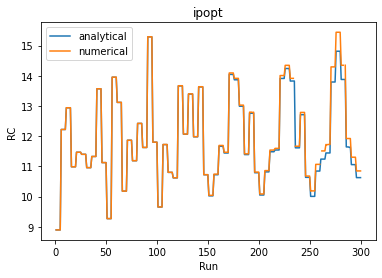

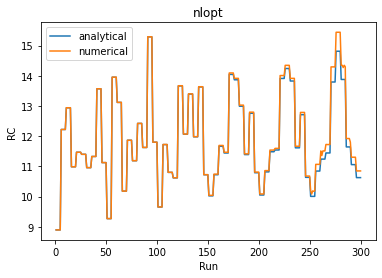

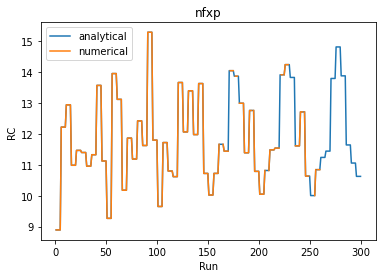

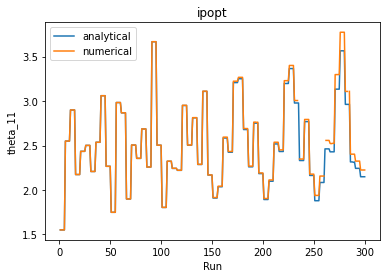

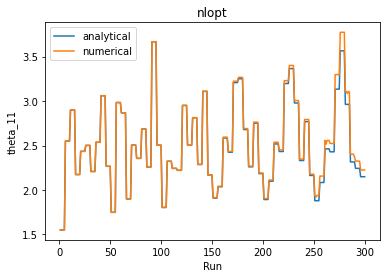

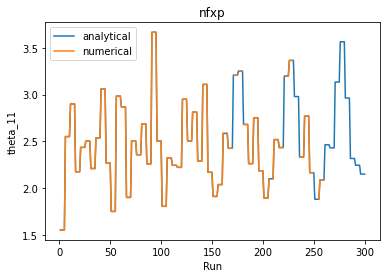

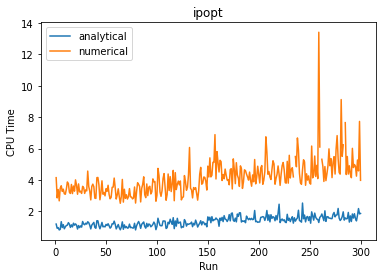

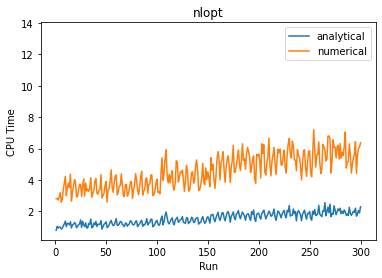

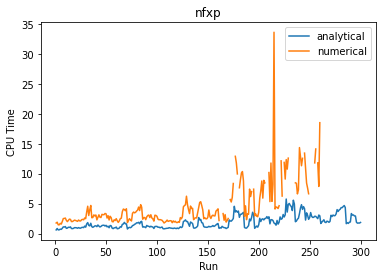

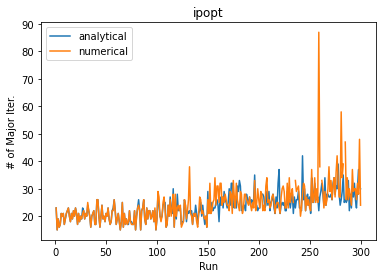

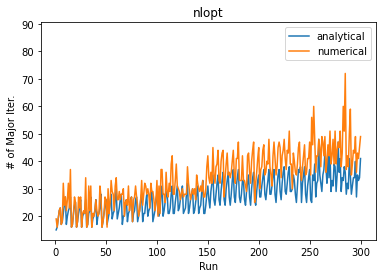

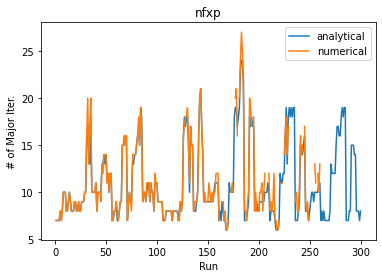

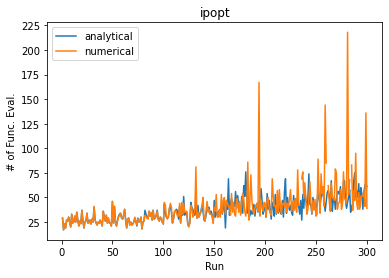

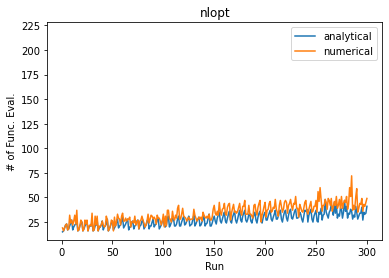

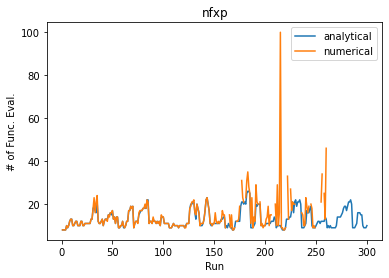

In [8]:
# comparison plots
create_plots(results)

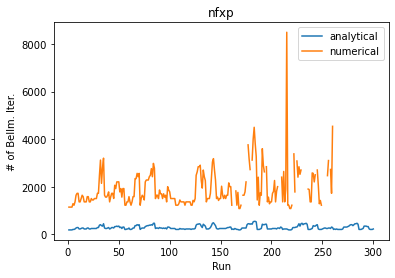

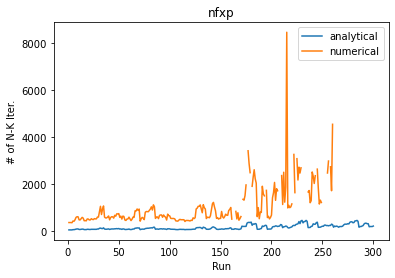

In [9]:
# Let's have a look at the amount of Bellman and N-K steps needed in the nested fixed point algorithm
create_nfxp_plots(results)

### References

Su, C.‐L. and Judd, K.L. (2012), Constrained Optimization Approaches to Estimation of Structural Models. Econometrica, 80: 2213-2230. doi:10.3982/ECTA7925

Dubé, J.‐P., Fox, J.T. and Su, C.‐L. (2012), Improving the Numerical Performance of Static and Dynamic Aggregate Discrete Choice Random Coefficients Demand Estimation. Econometrica, 80: 2231-2267. doi:10.3982/ECTA8585

Dong, Baiyu and Hsieh, Yu-Wei and Zhang, Xing, Implementing Maximum Likelihood Estimation of Empirical Matching Models: MPEC versus NFXP (April 20, 2017). USC-INET Research Paper No. 17-16. Available at SSRN: https://ssrn.com/abstract=2959116 or http://dx.doi.org/10.2139/ssrn.2959116